# Object Detection
ดร.ไพรสันต์ ผดุงเวียง


2024, College of Computing, KKU

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Single object, Multi-class

In [5]:
# 1. Generate a simple shape dataset
class ShapeDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=64):
        self.num_samples = num_samples
        self.image_size = image_size
        self.shapes = ['circle', 'rectangle']
        self.data = []
        self.generate_data()

    def generate_data(self):
        for _ in range(self.num_samples):
            img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
            shape = np.random.choice(self.shapes)
            x = np.random.randint(10, self.image_size - 10)
            y = np.random.randint(10, self.image_size - 10)
            size = np.random.randint(10, 20)

            if shape == 'circle':
                rr, cc = np.ogrid[:self.image_size, :self.image_size]
                dist = np.sqrt((rr - y) ** 2 + (cc - x) ** 2)
                img[dist <= size] = 1
            else:  # rectangle
                img[y-size//2:y+size//2, x-size//2:x+size//2] = 1

            label = [self.shapes.index(shape), x / self.image_size, y / self.image_size, size / self.image_size]
            self.data.append((img, label))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return torch.tensor(img).unsqueeze(0), torch.tensor(label)


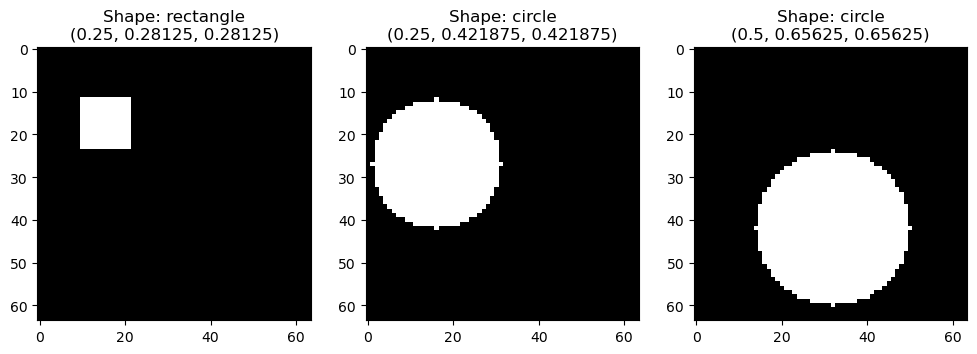

In [6]:
# prompt: show 3 ShapeDataset
import matplotlib.pyplot as plt
# Create a dataset
dataset = ShapeDataset(num_samples=1000, image_size=64)

# Display 3 samples
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
  img, label = dataset[i]
  axs[i].imshow(img.squeeze(), cmap='gray')
  axs[i].set_title(f"Shape: {dataset.shapes[int(label[0])]}\n{label[1].item(),label[2].item(),label[2].item()}")
plt.show()


In [4]:
# 2. Create a CNN model for object detection
class SimpleObjectDetector(nn.Module):
    def __init__(self):
        super(SimpleObjectDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 outputs: class, x, y, size

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# 3. Train the model
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = ShapeDataset()
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
# Create and train the model
model = SimpleObjectDetector()
model.to(device)
train_model(model, train_loader, num_epochs=15)

Epoch 1, Loss: 0.0750
Epoch 2, Loss: 0.0238
Epoch 3, Loss: 0.0130
Epoch 4, Loss: 0.0079
Epoch 5, Loss: 0.0040
Epoch 6, Loss: 0.0010
Epoch 7, Loss: 0.0005
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0002
Epoch 10, Loss: 0.0001
Epoch 11, Loss: 0.0001
Epoch 12, Loss: 0.0001
Epoch 13, Loss: 0.0001
Epoch 14, Loss: 0.0001
Epoch 15, Loss: 0.0001


In [10]:
# 4. Visualize the results
def visualize_results(model, test_loader, num_images=5):
    model.eval()
    fig, axs = plt.subplots(num_images, 2, figsize=(8, 3*num_images))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i >= num_images:
                break

            inputs_gpu = inputs.to(device)
            outputs = model(inputs_gpu)



            # Original image
            axs[i, 0].imshow(inputs[0, 0].numpy(), cmap='gray')
            axs[i, 0].set_title('Original')

            # Predicted shape
            axs[i, 1].imshow(inputs[0, 0].numpy(), cmap='gray')
            pred_class, pred_x, pred_y, pred_size = outputs[0]
            pred_x, pred_y, pred_size = pred_x.item(), pred_y.item(), pred_size.item()

            # Convert normalized coordinates to pixel coordinates
            pixel_x, pixel_y = int(pred_x * 64), int(pred_y * 64)
            pixel_size = int(pred_size * 64)

            print([pred_class.item(), pred_x, pred_y, pred_size])

            if pred_class < 0.5:  # Circle
                circle = plt.Circle((pixel_x, pixel_y), pixel_size/2, fill=False, edgecolor='red')
                axs[i, 1].add_artist(circle)
                shape_name = "Circle"
            else:  # Rectangle
                rect = plt.Rectangle((pixel_x - pixel_size/2, pixel_y - pixel_size/2),
                                     pixel_size, pixel_size,
                                     fill=False, edgecolor='red')
                axs[i, 1].add_patch(rect)
                shape_name = "Rectangle"


            axs[i, 1].set_title(f'{shape_name} {pixel_x, pixel_y, pixel_size}')
            axs[i, 1].set_xlim(0, 64)
            axs[i, 1].set_ylim(64, 0)  # Invert y-axis to match image coordinates

    plt.tight_layout()
    plt.show()

[0.015570439398288727, 0.6763091683387756, 0.7986498475074768, 0.23703691363334656]
[0.010021083056926727, 0.23776006698608398, 0.4231524169445038, 0.16124573349952698]
[0.003212176263332367, 0.3244918882846832, 0.5052127838134766, 0.16766780614852905]
[0.9065536260604858, 0.16131681203842163, 0.6409401297569275, 0.26782283186912537]
[0.9987397193908691, 0.46986693143844604, 0.5493841767311096, 0.2226860076189041]


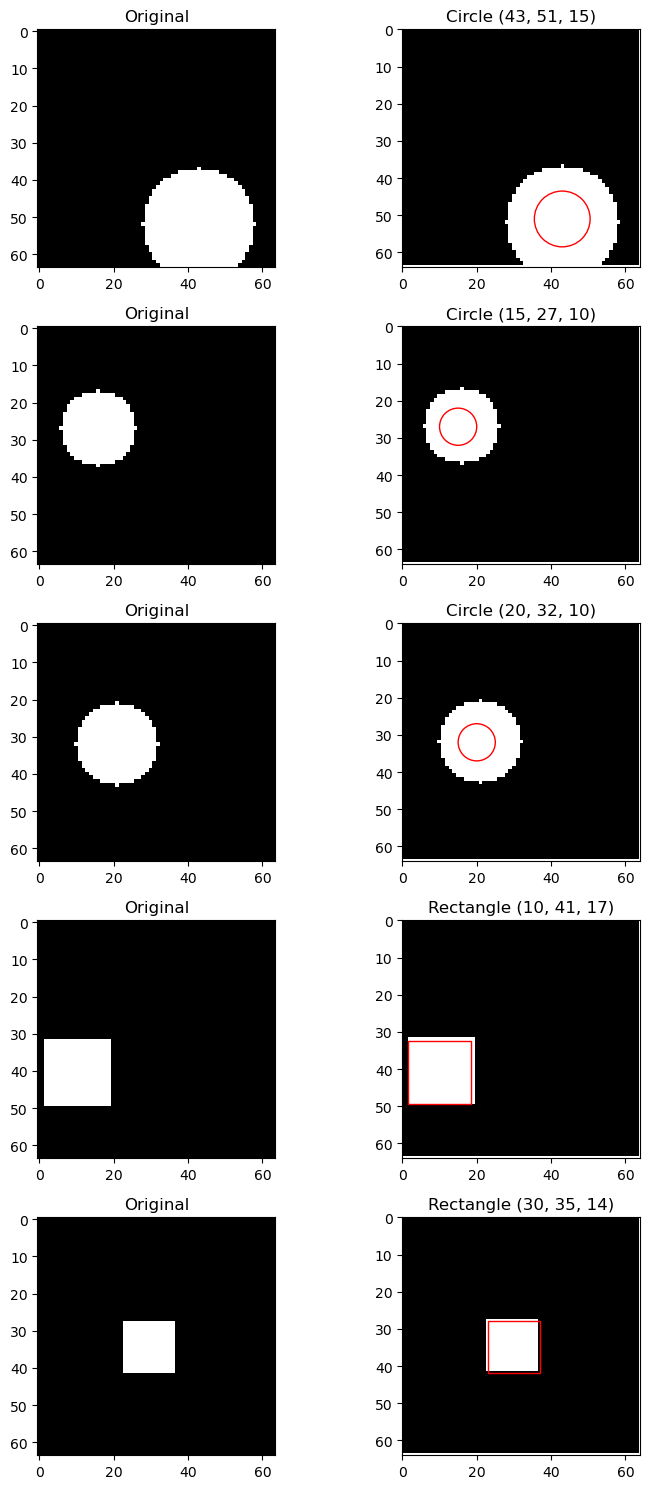

In [11]:
# Visualize results
test_dataset = ShapeDataset(num_samples=100)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
visualize_results(model, test_loader)

In [12]:
class FPNObjectDetector(nn.Module):
    def __init__(self):
        super(FPNObjectDetector, self).__init__()

        # Bottom-up layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        # Top-down layers
        self.toplayer = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.lat3 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.lat2 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        self.lat1 = nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0)

        # Smooth layers
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        # Output layer
        self.output = nn.Conv2d(256, 4, kernel_size=3, stride=1, padding=1)

    def _upsample_add(self, x, y):
        return nn.functional.interpolate(x, scale_factor=2, mode='nearest') + y

    def forward(self, x):
        # Bottom-up
        c1 = torch.relu(self.conv1(x))
        c2 = torch.relu(self.conv2(c1))
        c3 = torch.relu(self.conv3(c2))
        c4 = torch.relu(self.conv4(c3))

        # Top-down
        p4 = self.toplayer(c4)
        p3 = self._upsample_add(p4, self.lat3(c3))
        p2 = self._upsample_add(p3, self.lat2(c2))
        p1 = self._upsample_add(p2, self.lat1(c1))

        # Smooth
        p3 = self.smooth3(p3)
        p2 = self.smooth2(p2)
        p1 = self.smooth1(p1)

        # Output
        out = self.output(p1)
        return out.view(out.size(0), 4, -1).mean(dim=2)  # Average predictions across all locations


In [ ]:
model = FPNObjectDetector()
model.to(device)
train_model(model, train_loader, num_epochs=15)

[1.0232298374176025, 0.21195363998413086, 0.49295440316200256, 0.2735564708709717]
[0.983467698097229, 0.7561211585998535, 0.4857032299041748, 0.18663975596427917]
[0.03477279096841812, 0.46394503116607666, 0.8681701421737671, 0.32586926221847534]
[-0.043807804584503174, 0.8096145391464233, 0.4660857021808624, 0.24372687935829163]
[0.09917405992746353, 0.557132363319397, 0.4952062666416168, 0.16419336199760437]


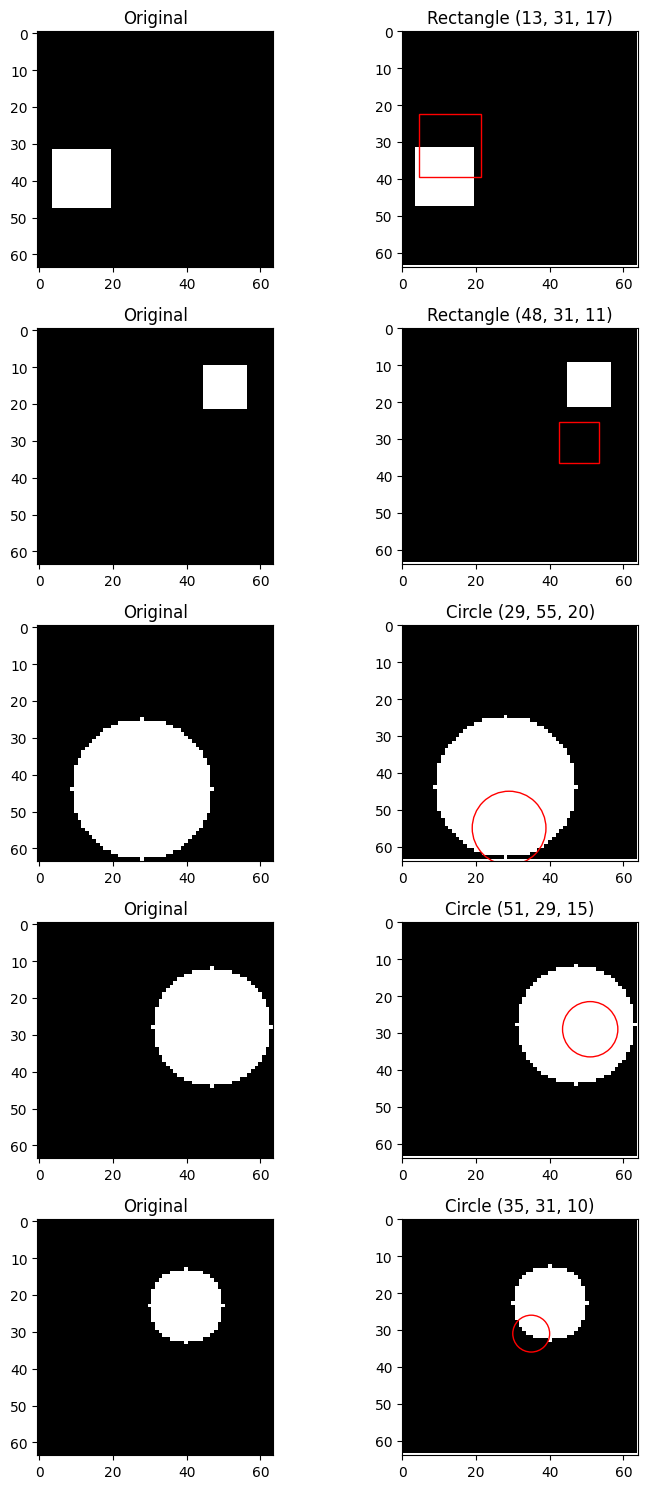

In [ ]:
# Visualize results
test_dataset = ShapeDataset(num_samples=100)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
visualize_results(model, test_loader)

# Multi-object, Multi-class

In [7]:
class MultiShapeDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=64, max_objects=2):
        self.num_samples = num_samples
        self.image_size = image_size
        self.max_objects = max_objects
        self.shapes = ['circle', 'rectangle']
        self.data = []
        self.generate_data()

    def generate_data(self):
        for _ in range(self.num_samples):
            img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
            labels = []

            num_objects = np.random.randint(0, self.max_objects + 1)  # Random number of objects (0 to 2)

            for _ in range(num_objects):
                shape = np.random.choice(self.shapes)
                x = np.random.randint(10, self.image_size - 10)
                y = np.random.randint(10, self.image_size - 10)
                size = np.random.randint(8, 16)

                if shape == 'circle':
                    rr, cc = np.ogrid[:self.image_size, :self.image_size]
                    dist = np.sqrt((rr - y) ** 2 + (cc - x) ** 2)
                    img[dist <= size] = 1
                else:  # rectangle
                    img[y-size//2:y+size//2, x-size//2:x+size//2] = 1

                labels.append([self.shapes.index(shape), x / self.image_size, y / self.image_size, size / self.image_size])

            # Pad labels to always have max_objects
            while len(labels) < self.max_objects:
                labels.append([-1, 0, 0, 0])  # Use -1 as class index to indicate no object

            self.data.append((img, labels))

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img, labels = self.data[idx]
        return torch.tensor(img).unsqueeze(0), torch.tensor(labels)

tensor([[ 1.0000,  0.4375,  0.1719,  0.2031],
        [-1.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000]])
tensor([[0.0000, 0.1719, 0.2188, 0.1719],
        [0.0000, 0.3906, 0.7500, 0.1875],
        [1.0000, 0.2812, 0.2031, 0.2031]])
tensor([[1.0000, 0.5781, 0.4375, 0.2344],
        [0.0000, 0.4375, 0.8281, 0.2031],
        [1.0000, 0.6406, 0.1719, 0.2188]])
tensor([[ 0.0000,  0.2031,  0.7500,  0.2031],
        [-1.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000]])


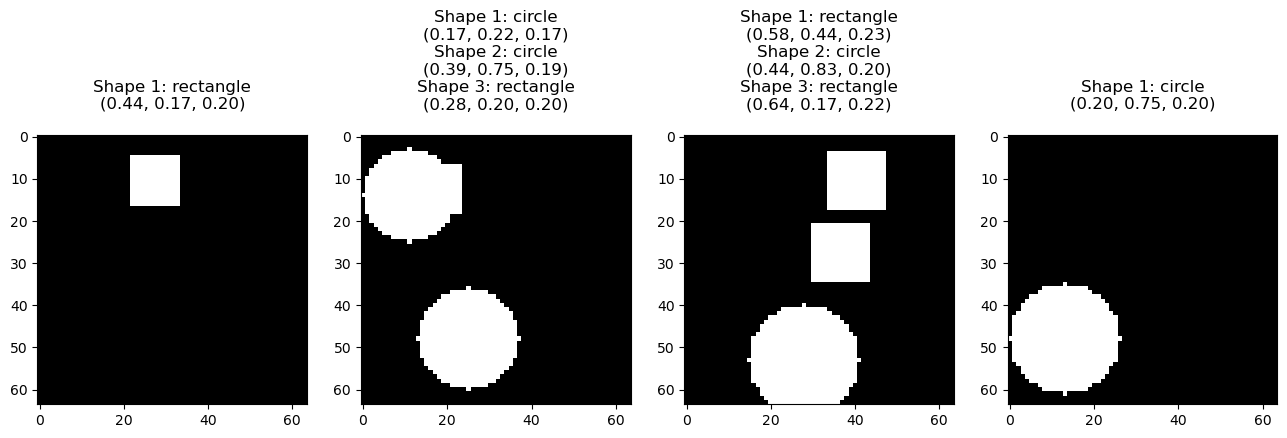

In [13]:
# prompt: show 4 MultiShapeDataset

import matplotlib.pyplot as plt
# Create a dataset
multi_dataset = MultiShapeDataset(num_samples=1000, image_size=64, max_objects=3)

# Display 4 samples
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
  img, labels = multi_dataset[i]
  print(labels)
  axs[i].imshow(img.squeeze(), cmap='gray')
  title = ""
  for j, label in enumerate(labels):
    if label[0] != -1:  # Only show objects that exist
      shape = multi_dataset.shapes[int(label[0])]
      x, y, size = label[1:].tolist()
      title += f"Shape {j+1}: {shape}\n({x:.2f}, {y:.2f}, {size:.2f})\n"
  axs[i].set_title(title)
plt.show()


In [ ]:
class MultiObjectDetector(nn.Module):
    def __init__(self, max_objects=2):
        super(MultiObjectDetector, self).__init__()
        self.max_objects = max_objects

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, max_objects * 4)  # 4 outputs per object: class, x, y, size
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 8 * 8)
        x = self.classifier(x)
        return x.view(-1, self.max_objects, 4)

In [ ]:
def train_model(model, train_loader, num_epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

In [ ]:
dataset = MultiShapeDataset(num_samples=5000, max_objects=2)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Create and train the model
model = MultiObjectDetector(max_objects=2)
train_model(model, train_loader, num_epochs=5)

Epoch 1, Loss: 0.0672
Epoch 2, Loss: 0.0382
Epoch 3, Loss: 0.0324
Epoch 4, Loss: 0.0292
Epoch 5, Loss: 0.0264


In [ ]:
def visualize_results(model, test_loader, num_images=5, device='cpu'):
    model = model.to(device)
    model.eval()
    fig, axs = plt.subplots(num_images, 2, figsize=(12, 5*num_images))

    shape_names = ['Circle', 'Rectangle','No Object']
    colors = ['g', 'r', 'b']

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if i >= num_images:
                break

            inputs = inputs.to(device)
            outputs = model(inputs)

            # Move outputs back to CPU for visualization
            outputs = outputs.cpu()

            # Original image
            axs[i, 0].imshow(inputs[0, 0].cpu().numpy(), cmap='gray')
            axs[i, 0].set_title('Original')
            axs[i, 0].axis('off')

            # Predicted shapes
            axs[i, 1].imshow(np.zeros((64, 64)), cmap='gray', vmin=0, vmax=1)
            print(outputs)

            for j in range(2):  # For each potential object
                pred_class, pred_x, pred_y, pred_size = outputs[0, j]
                pred_class, pred_x, pred_y, pred_size = pred_class.item(), pred_x.item(), pred_y.item(), pred_size.item()

                if pred_class > 0:  # If it's not "No Object"
                    pixel_x, pixel_y = int(pred_x * 64), int(pred_y * 64)
                    pixel_size = int(pred_size * 64)
                    pred_class= int(pred_class > 0.5)

                    if pred_class == 0:  # Circle
                        circle = plt.Circle((pixel_x, pixel_y), pixel_size/2, fill=False, edgecolor=colors[pred_class])
                        axs[i, 1].add_artist(circle)
                    else:  # Rectangle
                        rect = plt.Rectangle((pixel_x - pixel_size/2, pixel_y - pixel_size/2),
                                             pixel_size, pixel_size,
                                             fill=False, edgecolor=colors[pred_class])
                        axs[i, 1].add_patch(rect)

                    axs[i, 1].text(pixel_x, pixel_y, shape_names[pred_class], color=colors[pred_class],
                                   ha='center', va='center')

            axs[i, 1].set_title('Predicted')
            axs[i, 1].set_xlim(0, 64)
            axs[i, 1].set_ylim(64, 0)  # Invert y-axis to match image coordinates
            axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

tensor([[[ 0.0691,  0.2062,  0.3233,  0.2215],
         [-0.6866,  0.1004,  0.1395,  0.0779]]])
tensor([[[ 1.0355,  0.1312,  0.2783,  0.2135],
         [-0.6436,  0.0675,  0.0808,  0.0568]]])
tensor([[[-0.0117,  0.7146,  0.2850,  0.1571],
         [-0.7354,  0.1516,  0.0784,  0.0250]]])
tensor([[[ 1.1036,  0.7185,  0.5205,  0.2209],
         [-0.3133,  0.3471,  0.2207,  0.0979]]])
tensor([[[ 1.0273,  0.1870,  0.5927,  0.1979],
         [-0.4160,  0.0903,  0.1528,  0.0320]]])


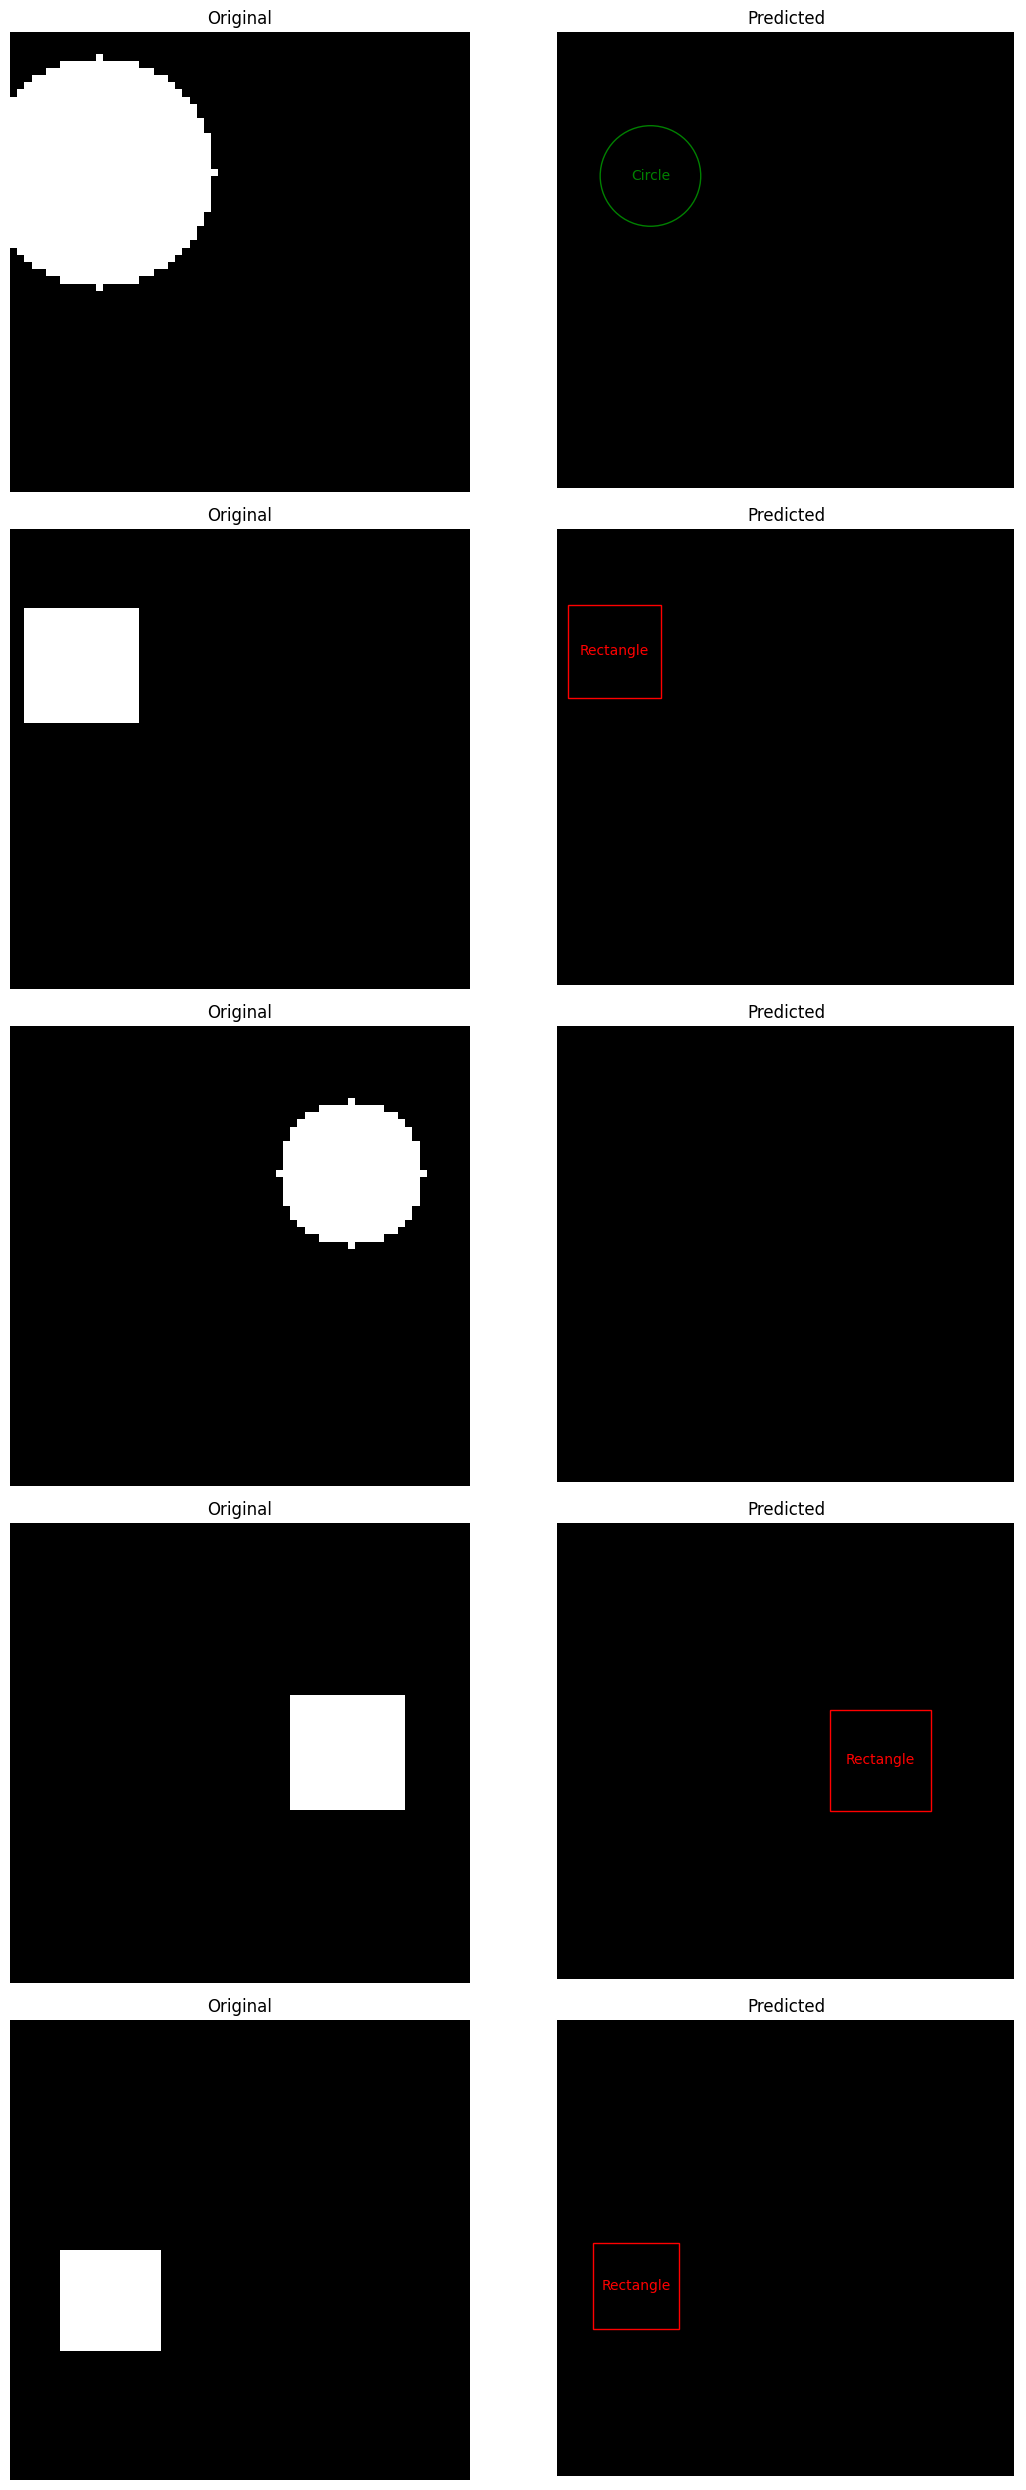

In [ ]:
# Visualize results
# test_dataset = MultiShapeDataset(num_samples=100, max_objects=2)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
visualize_results(model, test_loader)

# Hand on
Revise the code to be able to detect a maximum of 4 objects per image.

# High performance and well known model
https://pytorch.org/vision/stable/models.html

https://universe.roboflow.com/